In [2]:
# === Core Libraries ===
import os
import random
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from PIL import Image

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import (
    load_img, img_to_array, ImageDataGenerator
)

# === Pretrained CNN Models ===
from tensorflow.keras.applications import (
    ResNet50, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mob_preprocess
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


# === Machine Learning Models ===
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, KFold, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score
)
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold

# === Boosting Models ===
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# === Hyperparameter tunning ===
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV)


In [ ]:
#import tempfile, os
#os.environ['TMPDIR'] = 'D:/temp'
#os.environ['TEMP'] = 'D:/temp'
#os.environ['TMP'] = 'D:/temp'

# Make sure it exists
#os.makedirs('D:/temp', exist_ok=True)

### Function definion

In [4]:
# ============================================================
# FUNCTION: Z-score normalization per image (RGB)
# ============================================================
def zscore_normalize_rgb(img):
    img = np.array(img).astype(np.float32)
    mean = img.mean(axis=(0, 1), keepdims=True)
    std = img.std(axis=(0, 1), keepdims=True)
    std[std == 0] = 1.0
    img = (img - mean) / std
    return img

In [3]:
# ============================================================
# FUNCTION: Z-score across sets
# ============================================================
def z_score_across(set):
    mean = np.mean(set,axis = 0)
    std = np.std(set, axis = 0)
    std[std==0] = 1.0

    return (set - mean)/std

In [5]:
# ============================================================
# FUNCTION: load images with Z-score normalization per image
# ============================================================
def load_images_from_folder(listimag, label, target_size=(256, 256)):
    images, labels = [], []
    for path in listimag:
        img = Image.open(path).convert('RGB')
        img = img.resize(target_size)
        img = np.array(img).astype(np.float32)
        img = zscore_normalize_rgb(img)
        images.append(img.flatten())
        labels.append(label)
    return np.array(images), labels

In [6]:
# ============================================================
# FUNCTION: feature extraction using ResNet50
# ============================================================
def extract_features(img_path,label):
    images, labels = [], []
    for path in img_path:
        img = load_img(path, target_size=(256, 256))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = resnet_preprocess(x)
        features = model.predict(x)
        images.append(features.flatten())
        labels.append(label)
    return np.array(images), labels

In [7]:
# ============================================================
# FUNCTION: Preprocessing images to charge them in the CNN
# ============================================================
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        x = img_to_array(img)
        x = resnet_preprocess(x)
        images.append(x)
    
    # Stack all preprocessed images into a batch
    return np.stack(images, axis=0)

In [8]:
# ============================================================
# FUNCTION: load images raw with size parameter for pretrained CNNs
# ============================================================
def load_raw(paths, label,img_size=(224, 224)):
    imgs, labels = [], []
    for path in tqdm(paths, desc=f"Loading {'defective' if label == 1 else 'good'} images"):
        img = load_img(path, target_size=img_size)
        img = img_to_array(img)
        imgs.append(img)
        labels.append(label)
    return np.array(imgs), np.array(labels)

In [9]:
# ============================================================
# FUNCTION: data generator with augmentation and preprocessing
# =============================================================

def path_generator(paths, labels, batch_size, datagen):
    """Yields batches of preprocessed images and labels."""
    while True:
        idx = np.arange(len(paths))
        np.random.shuffle(idx)
        for i in range(0, len(paths), batch_size):
            batch_idx = idx[i:i+batch_size]
            batch_images = []
            batch_labels = []
            
            for j in batch_idx:
                img = load_img(paths[j], target_size=IMG_SIZE)
                img = img_to_array(img)
                
                img = datagen.random_transform(img)
                img = resnet_preprocess(img) 
                
                batch_images.append(img)
                batch_labels.append(labels[j])
                
            yield np.array(batch_images), np.array(batch_labels)

In [ ]:
# ============================================================
# FUNCTION: show predictions grid
# ============================================================
def show_predictions_grid(image_paths, preds, label_name, save_path=None, dpi=300):
    selected = [p for p, y in zip(image_paths, preds) if y == label_name]
    n = min(9, len(selected))
    plt.figure(figsize=(20, 20))
    for i, path in enumerate(selected[:n]):
        img = load_img(path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Predicted: {'Defective' if label_name else 'OK'}", fontsize=40)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=dpi, format='pdf')
    plt.show()

In [10]:
# Comprehensive reproducibility setup
BASE_SEED = 12345

# Set all possible random seeds for reproducibility
np.random.seed(BASE_SEED)
random.seed(BASE_SEED)
tf.random.set_seed(BASE_SEED)

# Configure TensorFlow for deterministic behavior
tf.config.experimental.enable_op_determinism()

# Set Python's hash seed for consistent hashing
os.environ['PYTHONHASHSEED'] = str(BASE_SEED)

print(f"All random seeds set to {BASE_SEED} for reproducibility")

All random seeds set to 12345 for reproducibility


### Setting directories

In [11]:
if not Path("data/raw/archive").exists():
    os.chdir("..")

print("Working directory:", os.getcwd())

#Setting up (relative) paths
train_dir = Path("data/raw/archive/train")
good_dir = train_dir / "good"
not_good_dir = train_dir / "not-good"
test_dir = Path("data/raw/archive/test")
processed_dir = Path("data/processed")

Working directory: d:\assigment-ai-ARIADNA-20251113\source-code-ai-ARIADNA-20251113


In [12]:
# Create directories for models and plots
models_dir = Path("checkpoints")
plots_dir = Path("plots")
models_dir.mkdir(exist_ok=True)
plots_dir.mkdir(exist_ok=True)

In [13]:
clusters = {}
not_good_img_paths = list(not_good_dir.glob("*.*"))
good_img_paths= list(good_dir.glob("*.*"))

Group "not-good" images by a key extracted from filenames in a dictionary 
We do this to ensure that augmented images are in the same ratio as original ones


In [14]:
for img_path in not_good_img_paths:
    name = img_path.stem  # filename without extension
    # Extract a "key" from filename
    key = name[:-3] if len(name) > 3 else name
    if key not in clusters:
        clusters[key] = []
    clusters[key].append(img_path)

# Show cluster info
for key, files in clusters.items():
    print(f"Cluster '{key}': {len(files)} images")


Cluster 'manipulated_front': 10 images
Cluster 'scratch_head': 10 images
Cluster 'scratch_neck': 10 images
Cluster 'thread_side': 10 images
Cluster 'thread_top': 10 images


### Image augmentation to balance class population

In [15]:
# Define output directory for augmented images
output_dir =  processed_dir / "not-good-augmented"
output_dir.mkdir(exist_ok=True)

In [16]:
# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=90,          
    horizontal_flip=True,   
    fill_mode='nearest'
)

# Generate augmented images
for key, files in clusters.items():
    output_dir.mkdir(exist_ok=True)

    n_aug_per_image = 4 # Number of augmented images needed per original image
    
    for img_path in files:
        img = load_img(img_path)  # keeps 1024x1024 RGB
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)  # (1, 1024, 1024, 3)
        
        # deterministic per-image seed derived from filepath + base
        h = hashlib.md5(str(img_path).encode()).hexdigest()
        per_image_seed = (int(h, 16) ^ BASE_SEED) & 0xFFFFFFFF

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, 
                                  batch_size=1, 
                                  save_to_dir=output_dir, 
                                  save_prefix=key,
                                  seed=int(per_image_seed),
                                  save_format='png'):
            img = np.squeeze(batch)
    
            i += 1
            if i >= n_aug_per_image:
                break

print("Augmentation complete!")


Augmentation complete!


In [17]:
not_good_img_paths += list(output_dir.glob("*.*"))

### ML models (benchmark)

In [18]:
# Load dataset (and apply z-score normalization per image)
ok_images, ok_labels = load_images_from_folder(good_img_paths, 0)
bad_images, bad_labels = load_images_from_folder(not_good_img_paths, 1)

X = np.vstack((ok_images, bad_images))
y = np.array(ok_labels + bad_labels)

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

Dataset loaded: 500 samples, 196608 features


In [19]:
# Define ML models for benchmarking
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF)": make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='scale', random_state=42)),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))
}


In [20]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n=== {name} ===")
    accs, f1s, precs, recs = [], [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recs.append(recall_score(y_test, y_pred))
    
    print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
    print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== Random Forest ===
Accuracy:  0.844 ± 0.023
F1-score:  0.841 ± 0.024
Precision: 0.861 ± 0.041
Recall:    0.824 ± 0.039

=== SVM (RBF) ===
Accuracy:  0.828 ± 0.019
F1-score:  0.808 ± 0.024
Precision: 0.914 ± 0.020
Recall:    0.724 ± 0.032

=== Logistic Regression ===
Accuracy:  0.814 ± 0.021
F1-score:  0.795 ± 0.029
Precision: 0.884 ± 0.010
Recall:    0.724 ± 0.054


### Feature extraction using ResNet50 

In [21]:
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

In [22]:
ok_features, ok_flabels = extract_features(good_img_paths, 0)
bad_features, bad_flabels = extract_features(not_good_img_paths, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [23]:
Xf = np.vstack((ok_features, bad_features))
yf = np.array(ok_flabels + bad_flabels)

print(f"Dataset loaded: {Xf.shape[0]} samples, {Xf.shape[1]} features")

Dataset loaded: 500 samples, 2048 features


In [24]:
# Z-score normalization of features across the dataset
Xf_normalized = z_score_across(Xf)

### ML with features as input

In [26]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n=== {name} ===")
    accs, f1s, precs, recs = [], [], [], []
    for train_idx, test_idx in skf.split(Xf_normalized, yf):
        X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
        y_train, y_test = yf[train_idx], yf[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recs.append(recall_score(y_test, y_pred))
    
    print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
    print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== Random Forest ===
Accuracy:  0.900 ± 0.032
F1-score:  0.890 ± 0.038
Precision: 0.985 ± 0.021
Recall:    0.812 ± 0.052

=== SVM (RBF) ===
Accuracy:  0.932 ± 0.030
F1-score:  0.927 ± 0.034
Precision: 0.982 ± 0.018
Recall:    0.880 ± 0.055

=== Logistic Regression ===
Accuracy:  0.954 ± 0.029
F1-score:  0.952 ± 0.032
Precision: 0.979 ± 0.019
Recall:    0.928 ± 0.056


## Gradient boosting ML models

In [27]:
# to dataframe
Xf_normalized_df = pd.DataFrame(Xf_normalized, columns=[f"f{i}" for i in range(Xf_normalized.shape[1])])

In [28]:
# Gradient Boosting Models

gbmodels = {
    "Extreme Gradient Boosting": XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
    ),
    "Light Gradient Boosting Machine": LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=20,
    subsample=0.8,
    random_state=42,
    verbose = -1
    )
}


In [29]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for name, model in gbmodels.items():
    print(f"\n=== {name} ===")
    accs, f1s, precs, recs = [], [], [], []
    for train_idx, test_idx in skf.split(Xf_normalized_df, yf):
        X_train, X_test = Xf_normalized_df.iloc[train_idx], Xf_normalized_df.iloc[test_idx]
        y_train, y_test = yf[train_idx], yf[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        precs.append(precision_score(y_test, y_pred))
        recs.append(recall_score(y_test, y_pred))
    
    print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
    print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
    print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
    print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== Extreme Gradient Boosting ===
Accuracy:  0.936 ± 0.032
F1-score:  0.932 ± 0.035
Precision: 0.986 ± 0.018
Recall:    0.884 ± 0.054

=== Light Gradient Boosting Machine ===
Accuracy:  0.934 ± 0.031
F1-score:  0.929 ± 0.035
Precision: 0.991 ± 0.011
Recall:    0.876 ± 0.065


## Small basic Neural Network

In [28]:
accs, f1s, precs, recs = [], [], [], []

for train_idx, test_idx in skf.split(Xf_normalized, yf):
    X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
    y_train, y_test = yf[train_idx], yf[test_idx]

    # Re-initialize the model for each fold
    input_dim = X_train.shape[1]
    model_fc = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model_fc.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

    # Fit the model
    model_fc.fit(X_train, y_train, epochs=30, batch_size=16, verbose=0)

    # Predict and threshold at 0.5
    y_pred = (model_fc.predict(X_test) > 0.5).astype(int)

    # Compute metrics
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))

print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/stepWARNING:tensorflow:5 out of the last 508 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F4A982BC70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy:  0.940 ± 0.024
F1-score:  0.938 ± 0

## Pre trained CNN models

In [30]:
# Parameters to use pretrained CNN models
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 6
N_SPLITS = 3
LR = 1e-4

In [31]:
# STEP 1: Load and preprocess images
X_good, y_good = load_raw(good_img_paths, 0, IMG_SIZE)
X_bad, y_bad = load_raw(not_good_img_paths, 1, IMG_SIZE)
X_raw = np.concatenate([X_good, X_bad], axis=0)
y = np.concatenate([y_good, y_bad], axis=0)

print("Raw dataset:", X_raw.shape, y.shape)

Loading defective images: 100%|██████████| 250/250 [00:05<00:00, 43.67it/s]


Raw dataset: (500, 224, 224, 3) (500,)


In [34]:
# STEP 2: Define architectures and preprocessing functions
architectures = {
    "EfficientNetB0": (EfficientNetB0, eff_preprocess),
    "MobileNetV2": (MobileNetV2, mob_preprocess),
    "ResNet50": (ResNet50, resnet_preprocess),
}

In [35]:
# STEP 3: Evaluation loop with 3-fold CV
results = {}

for name, (ModelClass, preprocess_fn) in architectures.items():
    print(f"\n===========================")
    print(f" Evaluating {name}")
    print(f"===========================")

    # Preprocess specifically for this architecture
    X = preprocess_fn(X_raw.copy())

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
    accs, precs, recs, f1s = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n---- Fold {fold}/{N_SPLITS} ----")

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Build base model
        base_model = ModelClass(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
        base_model.trainable = False  # feature extraction phase

        # Add custom classifier
        model = Sequential([
            base_model,
            GlobalAveragePooling2D(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(learning_rate=LR),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        # Train
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1
        )

        # Evaluate
        y_pred = (model.predict(X_val) > 0.5).astype(int)
        acc = accuracy_score(y_val, y_pred)
        prec = precision_score(y_val, y_pred)
        rec = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        print(f"Fold {fold} -> acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}")
        accs.append(acc); precs.append(prec); recs.append(rec); f1s.append(f1)

    results[name] = {
        "acc_mean": np.mean(accs),
        "acc_std": np.std(accs),
        "prec": np.mean(precs),
        "prec_std": np.std(precs),
        "rec": np.mean(recs),
        "rec_std": np.std(recs),
        "f1": np.mean(f1s),
        "f1_std": np.std(f1s)
    }


 Evaluating EfficientNetB0

---- Fold 1/3 ----
Epoch 1/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 434ms/step - accuracy: 0.5315 - loss: 0.7065 - val_accuracy: 0.6347 - val_loss: 0.6462
Epoch 2/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 297ms/step - accuracy: 0.6817 - loss: 0.6218 - val_accuracy: 0.7605 - val_loss: 0.5829
Epoch 3/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.6907 - loss: 0.5958 - val_accuracy: 0.7964 - val_loss: 0.5400
Epoch 4/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 313ms/step - accuracy: 0.7087 - loss: 0.5601 - val_accuracy: 0.8204 - val_loss: 0.5024
Epoch 5/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.7778 - loss: 0.5050 - val_accuracy: 0.8263 - val_loss: 0.4704
Epoch 6/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 346ms/step - accuracy: 0.7808 - loss: 0.4918 - val_accuracy: 0.8503 - val_loss: 0.4454
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 787ms/step
Fold 1 -> acc=0.850, prec=1.000, rec=0.699, f1=0.823

---- Fold 2/3 ----
Epoch 1/6
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - accuracy: 0.5526 - loss

In [36]:
# STEP 4: Summary of all architectures
print("\n=== Model Comparison Summary ===")
for name, metrics in results.items():
    print(f"{name:15s} | Acc: {metrics['acc_mean']:.3f} ± {metrics['acc_std']:.3f} | "
          f"Prec: {metrics['prec']:.3f} ± {metrics['prec_std']:.3f} | Rec: {metrics['rec']:.3f} ± {metrics['rec_std']:.3f} | F1: {metrics['f1']:.3f} ± {metrics['f1_std']:.3f}")

best_model = max(results.items(), key=lambda kv: kv[1]['f1'])
print(f"\nBest model: {best_model[0]} with F1 = {best_model[1]['f1']:.3f}")


=== Model Comparison Summary ===
EfficientNetB0  | Acc: 0.844 ± 0.013 | Prec: 0.948 ± 0.053 | Rec: 0.732 ± 0.025 | F1: 0.824 ± 0.010
MobileNetV2     | Acc: 0.838 ± 0.032 | Prec: 0.861 ± 0.041 | Rec: 0.808 ± 0.046 | F1: 0.833 ± 0.035
ResNet50        | Acc: 0.922 ± 0.013 | Prec: 0.950 ± 0.029 | Rec: 0.892 ± 0.020 | F1: 0.920 ± 0.012

Best model: ResNet50 with F1 = 0.920


## Fine Tunning of a pretrained CNN

In [73]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS_TOP = 10
EPOCHS_FINE = 20

In [74]:
# Prepare dataset
all_img_paths = good_img_paths + not_good_img_paths
labels = [0]*len(good_img_paths) + [1]*len(not_good_img_paths)  # 0 = good, 1 = damaged

# Split into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_img_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

In [75]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,          
    horizontal_flip=True,       
    fill_mode='nearest'         
)
val_datagen = ImageDataGenerator()

In [ ]:
train_gen = path_generator(train_paths, train_labels, BATCH_SIZE, train_datagen)
val_gen = path_generator(val_paths, val_labels, BATCH_SIZE, val_datagen)

steps_train = len(train_paths) // BATCH_SIZE
steps_val = len(val_paths) // BATCH_SIZE

# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False  # freeze base first

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Phase 1: Train top layers
model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_TOP
    #callbacks=callbacks 
)


# Phase 2: Fine-tune last layers
base_model.trainable = True
for layer in base_model.layers:
    if 'conv4' not in layer.name and 'conv5' not in layer.name:
        layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_FINE
    #callbacks=callbacks 
)

# Evaluate on validation set
val_images = []
for p in val_paths:
    img = img_to_array(load_img(p, target_size=IMG_SIZE))
    img = resnet_preprocess(img) 
    val_images.append(img)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

pred_probs = model.predict(val_images)
pred_labels = (pred_probs.flatten() > 0.5).astype(int)

acc = accuracy_score(val_labels, pred_labels)
prec = precision_score(val_labels, pred_labels)
rec = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print("Validation Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

# Save the model
model.save(models_dir / "resnet50_screw_finetuned_augmented.keras")

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5775 - loss: 0.9161 - val_accuracy: 0.5938 - val_loss: 0.7796
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6850 - loss: 0.5867 - val_accuracy: 0.8333 - val_loss: 0.3869
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8000 - loss: 0.4515 - val_accuracy: 0.8690 - val_loss: 0.4076
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8275 - loss: 0.3851 - val_accuracy: 0.8854 - val_loss: 0.2880
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8450 - loss: 0.3596 - val_accuracy: 0.8571 - val_loss: 0.3390
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8600 - loss: 0.3227 - val_accuracy: 0.8542 - val_loss: 0.2992
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8975 - loss: 0.2953 - val_accuracy: 0.8929 - val_loss: 0.2762
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8975 - loss: 0.2527 - val_accuracy: 0.8854 - val_loss:

## Hyperparamter tuning of the best performing models

After comparing all the model performance I selected Logistic regression, XGBC, LGBM, ResNet50 (with fine tunning), and the simple NN.

I do not have a GPU so this part is not optimal.

### Logistic regression (with features extracted as input)

In [93]:

log_reg = LogisticRegression(max_iter=1000, random_state=42)

param_grid_lr = {
    'C': [0.0001,0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

grid_lr = GridSearchCV(log_reg, param_grid_lr,
                       cv=5, scoring='precision', n_jobs=-1, verbose=2)
grid_lr.fit(Xf_normalized, yf)

print("Best LR params:", grid_lr.best_params_)
print("Best LR Precision:", grid_lr.best_score_)
print("Best Estimator:", grid_lr.best_estimator_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best LR params: {'C': 0.001, 'solver': 'liblinear'}
Best LR Precision: 0.9960000000000001
Best Estimator: LogisticRegression(C=0.001, max_iter=1000, random_state=42, solver='liblinear')


In [94]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_lg= LogisticRegression(C=grid_lr.best_params_['C'],
                             solver=grid_lr.best_params_['solver'],
                             max_iter=1000, random_state=42)

print("\n=== Logistic Regression ===")
accs, f1s, precs, recs = [], [], [], []
for train_idx, test_idx in skf.split(Xf_normalized, yf):
    X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
    y_train, y_test = yf[train_idx], yf[test_idx]
    
    final_lg.fit(X_train, y_train)
    y_pred = final_lg.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))

print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== Logistic Regression ===
Accuracy:  0.920 ± 0.024
F1-score:  0.913 ± 0.029
Precision: 0.996 ± 0.009
Recall:    0.844 ± 0.050


### XGBC (with features extracted as input)

In [65]:
xgb = XGBClassifier(n_estimators=200,random_state=42)

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

param_grid_xgb = {
    'max_depth': [5,7],
    'learning_rate': [0.01,0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.05]
}

#I do not have a GPU to run it faster so I have tried few parameters only

grid_xgb = GridSearchCV(xgb, param_grid_xgb, 
                        cv=skf, scoring='precision', n_jobs=-1, verbose=20)
grid_xgb.fit(Xf_normalized_df, yf)

print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB Precision:", grid_xgb.best_score_)
print("Best Estimator:", grid_xgb.best_estimator_)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best XGB params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8}
Best XGB Precision: 0.9864009093123325
Best Estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [71]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_xgbc = XGBClassifier(learning_rate=grid_xgb.best_params_['learning_rate'],
                            max_depth=grid_xgb.best_params_['max_depth'],
                            subsample=grid_xgb.best_params_['subsample'],
                            colsample_bytree=grid_xgb.best_params_['colsample_bytree'],
                            gamma=grid_xgb.best_params_['gamma'],
                            n_estimators=200,random_state=42)

print("\n=== XGBClassifier ===")
accs, f1s, precs, recs = [], [], [], []
for train_idx, test_idx in skf.split(Xf_normalized, yf):
    X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
    y_train, y_test = yf[train_idx], yf[test_idx]
    
    final_xgbc.fit(X_train, y_train)
    y_pred = final_xgbc.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))

print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== XGBClassifier ===
Accuracy:  0.936 ± 0.032
F1-score:  0.932 ± 0.035
Precision: 0.986 ± 0.018
Recall:    0.884 ± 0.054


#### LGBM (with features extracted as input)

In [67]:
lgbm = LGBMClassifier(random_state=42)

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

param_grid_lgbm = {
    'n_estimators': [200, 300],
    'num_leaves': [20, 30],
    'max_depth': [-1, 5],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_lgbm = RandomizedSearchCV(lgbm, param_grid_lgbm, 
                         cv=skf, scoring='precision', n_jobs=-1,n_iter=30, verbose=20)
grid_lgbm.fit(Xf_normalized_df, yf)

print("Best LGBM params:", grid_lgbm.best_params_)
print("Best LGBM Precission:", grid_lgbm.best_score_)
print("Best Estimator:", grid_lgbm.best_estimator_)


Fitting 2 folds for each of 30 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 250, number of negative: 250
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 302683
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 2045
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [70]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

final_xgbc = XGBClassifier(learning_rate=grid_xgb.best_params_['learning_rate'],
                            max_depth=grid_xgb.best_params_['max_depth'],
                            subsample=grid_xgb.best_params_['subsample'],
                            colsample_bytree=grid_xgb.best_params_['colsample_bytree'],
                            gamma=grid_xgb.best_params_['gamma'],
                            n_estimators=200,random_state=42)

print("\n=== LGBM  ===")
accs, f1s, precs, recs = [], [], [], []
for train_idx, test_idx in skf.split(Xf_normalized, yf):
    X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
    y_train, y_test = yf[train_idx], yf[test_idx]
    
    final_xgbc.fit(X_train, y_train)
    y_pred = final_xgbc.predict(X_test)

    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))

print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")


=== LGBM  ===
Accuracy:  0.936 ± 0.032
F1-score:  0.932 ± 0.035
Precision: 0.986 ± 0.018
Recall:    0.884 ± 0.054


#### Small NN (with features extracted as input)

In [39]:
def build_nn(learning_rate=1e-3, neurons1=512, neurons2=128, dropout1=0.5, dropout2=0.3):
    model = Sequential([
        Input(shape=(Xf_normalized.shape[1],)),
        Dense(neurons1, activation='relu'),
        Dropout(dropout1),
        Dense(neurons2, activation='relu'),
        Dropout(dropout2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
nn_model = KerasClassifier(
    model=build_nn,
    epochs=30,
    batch_size=16,
    verbose=0
)

In [ ]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

param_grid_nn = {
    "model__learning_rate": [1e-4, 1e-3],
    "model__neurons1": [256, 512],
    "model__neurons2": [64, 128, 200],
    "model__dropout1": [0.6, 0.5],
    "model__dropout2": [0.3, 0.4],
    "batch_size": [16, 32],
    "epochs": [10,20, 30]
}

grid_nn = RandomizedSearchCV(nn_model, param_grid_nn, cv=skf, scoring='f1', n_iter=40, verbose=100, n_jobs=-1, random_state=42)
grid_nn.fit(Xf_normalized, yf)

print("Best NN params:", grid_nn.best_params_)
print("Best NN f1:", grid_nn.best_score_)


Fitting 2 folds for each of 40 candidates, totalling 80 fits
Best NN params: {'model__neurons2': 200, 'model__neurons1': 512, 'model__learning_rate': 0.0001, 'model__dropout2': 0.3, 'model__dropout1': 0.5, 'epochs': 20, 'batch_size': 16}
Best NN f1: 0.9459855020059575


In [ ]:
# Parameters
BATCH_SIZE = grid_nn.best_params_['batch_size']
EPOCHS_TOP = grid_nn.best_params_['epochs']
LEARNING_RATE = grid_nn.best_params_['model__learning_rate']
NEURONS1 = grid_nn.best_params_['model__neurons1']
NEURONS2 = grid_nn.best_params_['model__neurons2']
DROPOUT1 = grid_nn.best_params_['model__dropout1']
DROPOUT2 = grid_nn.best_params_['model__dropout2']

In [81]:
# K-fold cross validation for each model
n_splits = 5                # K-fold
print("\n=== Neural Network ===")
accs, f1s, precs, recs = [], [], [], []

for train_idx, test_idx in skf.split(Xf_normalized, yf):
    X_train, X_test = Xf_normalized[train_idx], Xf_normalized[test_idx]
    y_train, y_test = yf[train_idx], yf[test_idx]

    # Re-initialize the model for each fold
    input_dim = X_train.shape[1]
    model_nn = build_nn(learning_rate=LEARNING_RATE, 
                        neurons1=NEURONS1, 
                        neurons2=NEURONS2, 
                        dropout1=DROPOUT1, 
                        dropout2=DROPOUT2)
    # Fit the model
    model_nn.fit(X_train, y_train, epochs=EPOCHS_TOP, batch_size=BATCH_SIZE, verbose=1)

    # Predict and threshold at 0.5
    y_pred = (model_nn.predict(X_test) > 0.5).astype(int)

    # Compute metrics
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    precs.append(precision_score(y_test, y_pred))
    recs.append(recall_score(y_test, y_pred))

print(f"Accuracy:  {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"F1-score:  {np.mean(f1s):.3f} ± {np.std(f1s):.3f}")
print(f"Precision: {np.mean(precs):.3f} ± {np.std(precs):.3f}")
print(f"Recall:    {np.mean(recs):.3f} ± {np.std(recs):.3f}")



=== Neural Network ===
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6040 - loss: 0.7152
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8200 - loss: 0.4310
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8920 - loss: 0.2785
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9400 - loss: 0.2276
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9160 - loss: 0.1873
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9600 - loss: 0.1216
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.1190
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9680 - loss: 0.1016
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.0618
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9720 - loss: 0.0835
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9880 - loss: 0.0581
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 

### Fine tuned ResNet50 (Pre-Trained model)

I would have like to improve the hyperparameters as I did with the other models, but my machine is not efficient enough. Instead  I will use what we learn from the hyperparameters of the previous simple NN given they have a similar architecture. 
I will fine tune this model and then measure its performance on the test data

In [ ]:
IMG_SIZE = (224, 224)
EPOCHS_FINE = 18

In [ ]:
train_gen = path_generator(train_paths, train_labels, BATCH_SIZE, train_datagen)
val_gen = path_generator(val_paths, val_labels, BATCH_SIZE, val_datagen)

steps_train = len(train_paths) // BATCH_SIZE
steps_val = len(val_paths) // BATCH_SIZE

# Build model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE,3))
base_model.trainable = False  # freeze base first

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(NEURONS1, activation='relu')(x)
x = Dropout(DROPOUT1)(x)
x = Dense(NEURONS2, activation='relu')(x)
x = Dropout(DROPOUT2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Phase 1: Train top layers
model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_TOP
    #callbacks=callbacks 
)


# Phase 2: Fine-tune last layers
base_model.trainable = True
for layer in base_model.layers:
    if 'conv4' not in layer.name and 'conv5' not in layer.name:
        layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(
    train_gen,
    steps_per_epoch=steps_train,
    validation_data=val_gen,
    validation_steps=steps_val,
    epochs=EPOCHS_FINE
    #callbacks=callbacks 
)

# Evaluate on validation set
val_images = []
for p in val_paths:
    img = img_to_array(load_img(p, target_size=IMG_SIZE))
    img = resnet_preprocess(img) 
    val_images.append(img)
val_images = np.array(val_images)
val_labels = np.array(val_labels)

pred_probs = model.predict(val_images)
pred_labels = (pred_probs.flatten() > 0.5).astype(int)

acc = accuracy_score(val_labels, pred_labels)
prec = precision_score(val_labels, pred_labels)
rec = recall_score(val_labels, pred_labels)
f1 = f1_score(val_labels, pred_labels)

print("Validation Metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

# Save the model
model.save(models_dir / "resnet50_2.keras")

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5600 - loss: 0.7824 - val_accuracy: 0.7396 - val_loss: 0.5750
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6575 - loss: 0.6093 - val_accuracy: 0.8095 - val_loss: 0.4803
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7500 - loss: 0.5290 - val_accuracy: 0.8333 - val_loss: 0.4617
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.7450 - loss: 0.5087 - val_accuracy: 0.8229 - val_loss: 0.4266
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8425 - loss: 0.4000 - val_accuracy: 0.9167 - val_loss: 0.2789
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8300 - loss: 0.3915 - val_accuracy: 0.8646 - val_loss: 0.3251
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8300 - loss: 0.3589 - val_accuracy: 0.7857 - val_loss: 0.4164
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8550 - loss: 0.3199 - val_accuracy: 0.8854 - val_loss:

## Testing data with the best models 

At the end this 2 models have shown to be the best performers, therefore I trained with all the training data to finally load the test data and proceed to do the actual test

In [33]:
test_img_paths = list(test_dir.glob("*.*"))

### Linear regression with feature extraction

In [52]:
fll = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

In [35]:
model = ResNet50(weights="imagenet", include_top=False, pooling="avg")
test_features, _ = extract_features(test_img_paths, 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms

In [51]:
# Z-score normalization using training set stats
Tf_normalized = (test_features - Xf.mean(axis=0)) / Xf.std(axis=0)


In [53]:
fll.fit(Xf_normalized, yf)
y_pred = fll.predict(Tf_normalized)

In [72]:
pd.DataFrame(y_pred).to_csv(models_dir/"resultsLF.csv", index=False)

### Resnet50

In [57]:
model = load_model(models_dir / "resnet50_screw_finetuned_augmented.keras")

Preprocessing the test data. My model was fine-tuned from ResNet50, so it expects: 224×224×3 image. Then we use the preprocess for resnet

In [58]:
test_ready = preprocess_images(test_img_paths)
y_pred2 = model.predict(test_ready)

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


In [62]:
y_labels2 = (y_pred2.flatten() > 0.5).astype(int)

In [63]:
pd.DataFrame(y_labels2).to_csv(models_dir/"resultsRN50.csv", index=False)

### Some comparisons

In [64]:
image_names = [f"test_{i+1}.png" for i in range(len(y_pred))]  
# Create a DataFrame
results_df = pd.DataFrame({
    "Image": image_names,
    "ResNet50_FineTuned": y_labels2,
    "LinearRegression": y_pred
})

# Optional: add agreement column
results_df["Agreement"] = np.where(results_df["ResNet50_FineTuned"] == results_df["LinearRegression"], "Yes", "No")

# Display neatly
print(results_df.head(10))

# Export CSV
results_df.to_csv(models_dir/"model_comparison_results.csv", index=False)

         Image  ResNet50_FineTuned  LinearRegression Agreement
0   test_1.png                   0                 0       Yes
1   test_2.png                   0                 0       Yes
2   test_3.png                   0                 0       Yes
3   test_4.png                   0                 0       Yes
4   test_5.png                   0                 0       Yes
5   test_6.png                   0                 0       Yes
6   test_7.png                   0                 0       Yes
7   test_8.png                   0                 0       Yes
8   test_9.png                   0                 0       Yes
9  test_10.png                   0                 0       Yes


In [63]:
summary = pd.DataFrame({
    "Model": ["ResNet50 Fine-Tuned", "Linear Regression"],
    "Predicted Defects": [y_labels2.sum(), y_pred.sum()],
    "Total Images": [len(y_labels2), len(y_pred)],
    "Positive Rate (%)": [y_labels2.mean()*100, y_pred.mean()*100]
})

print(summary)


                 Model  Predicted Defects  Total Images  Positive Rate (%)
0  ResNet50 Fine-Tuned                 79           180          43.888889
1    Linear Regression                 90           180          50.000000


### Linear regression (FE)

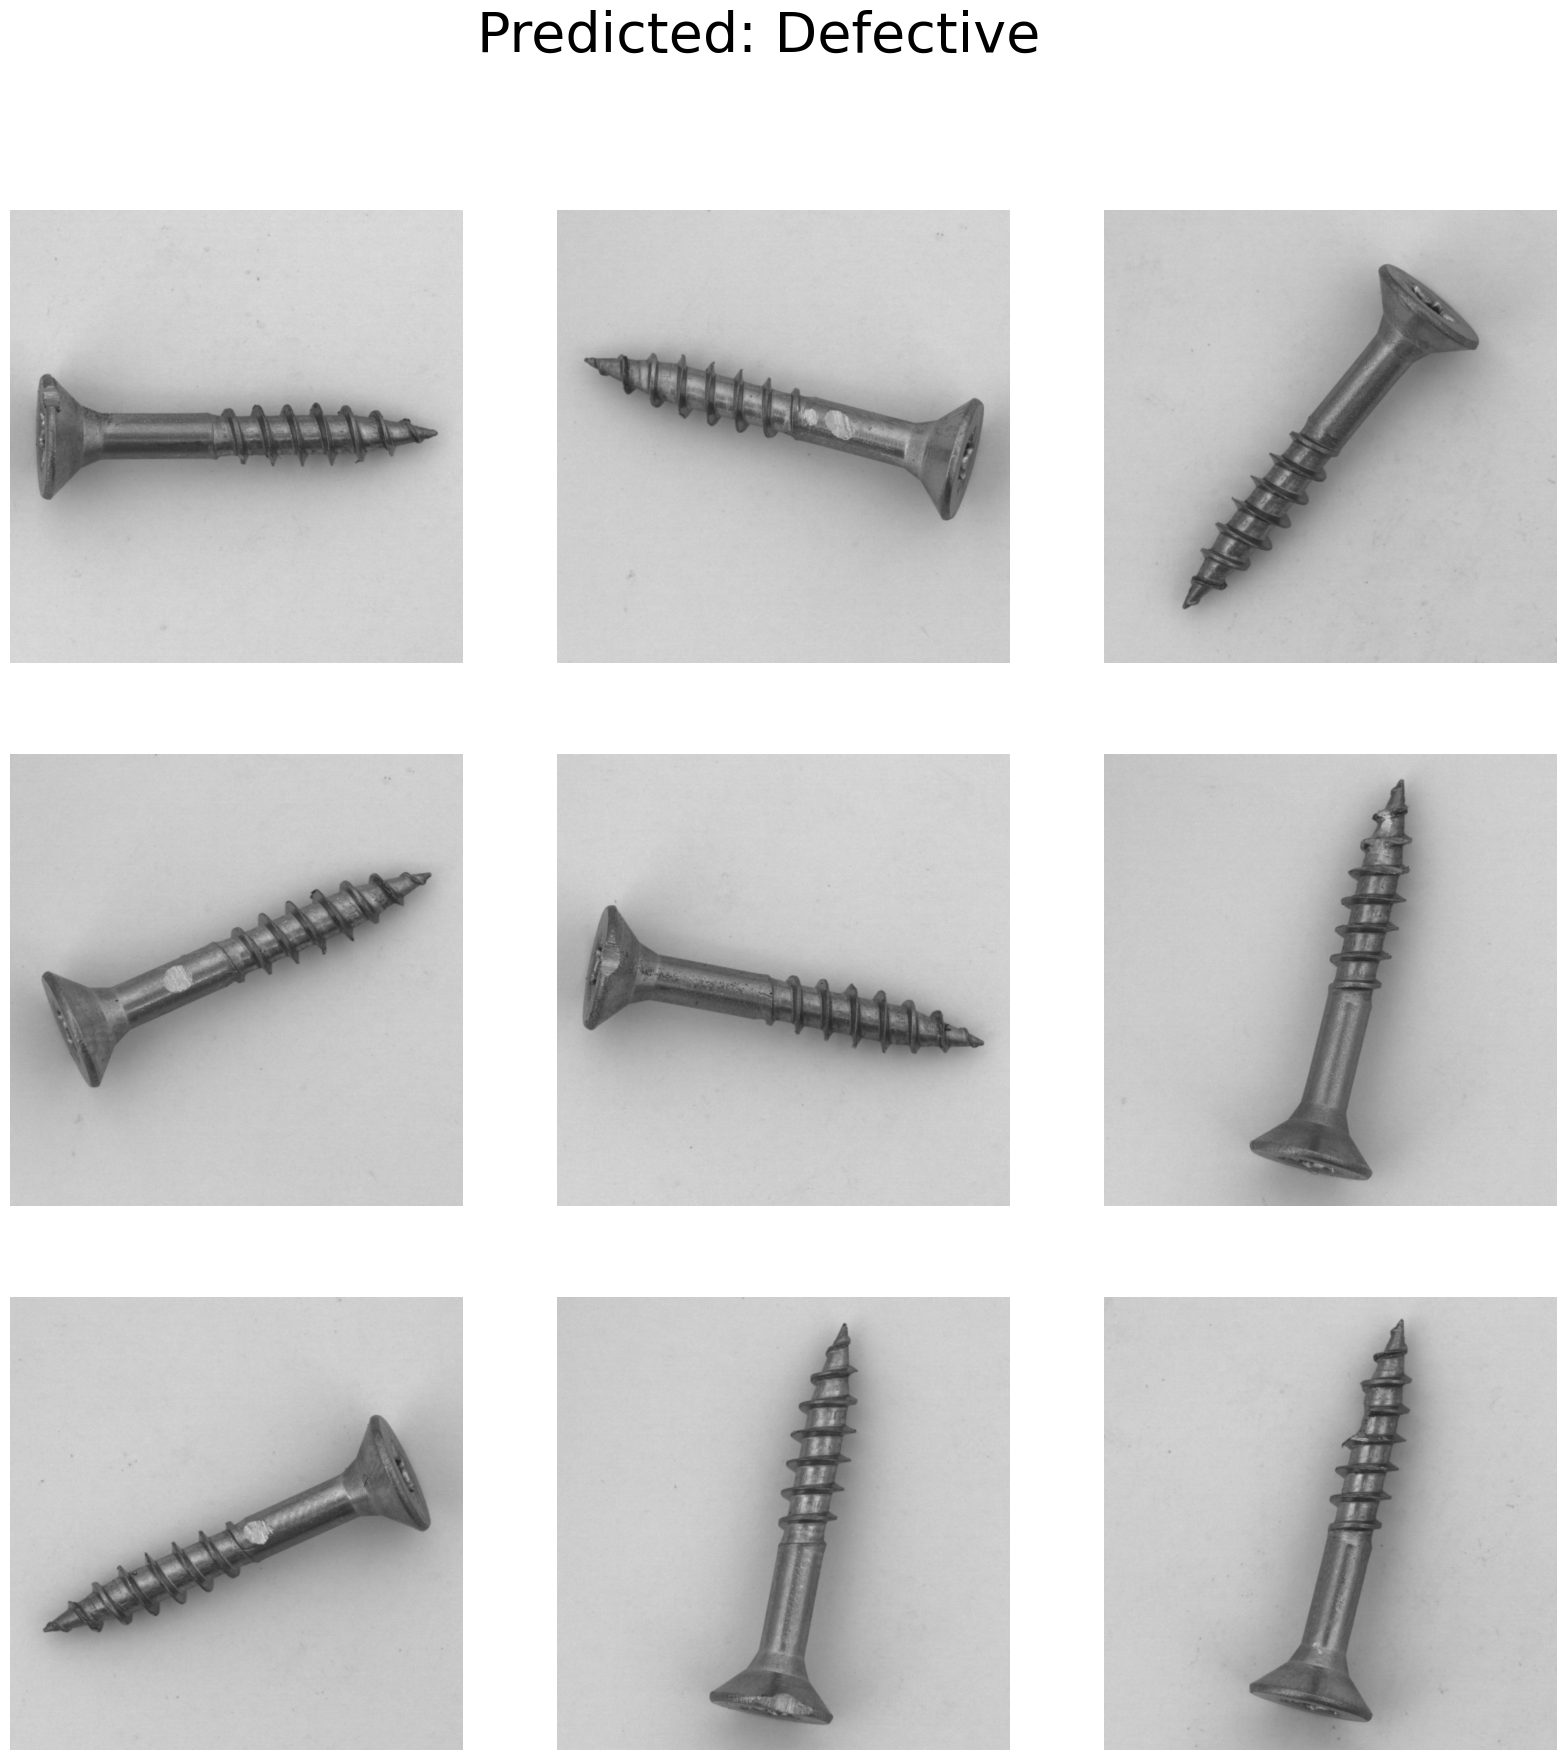

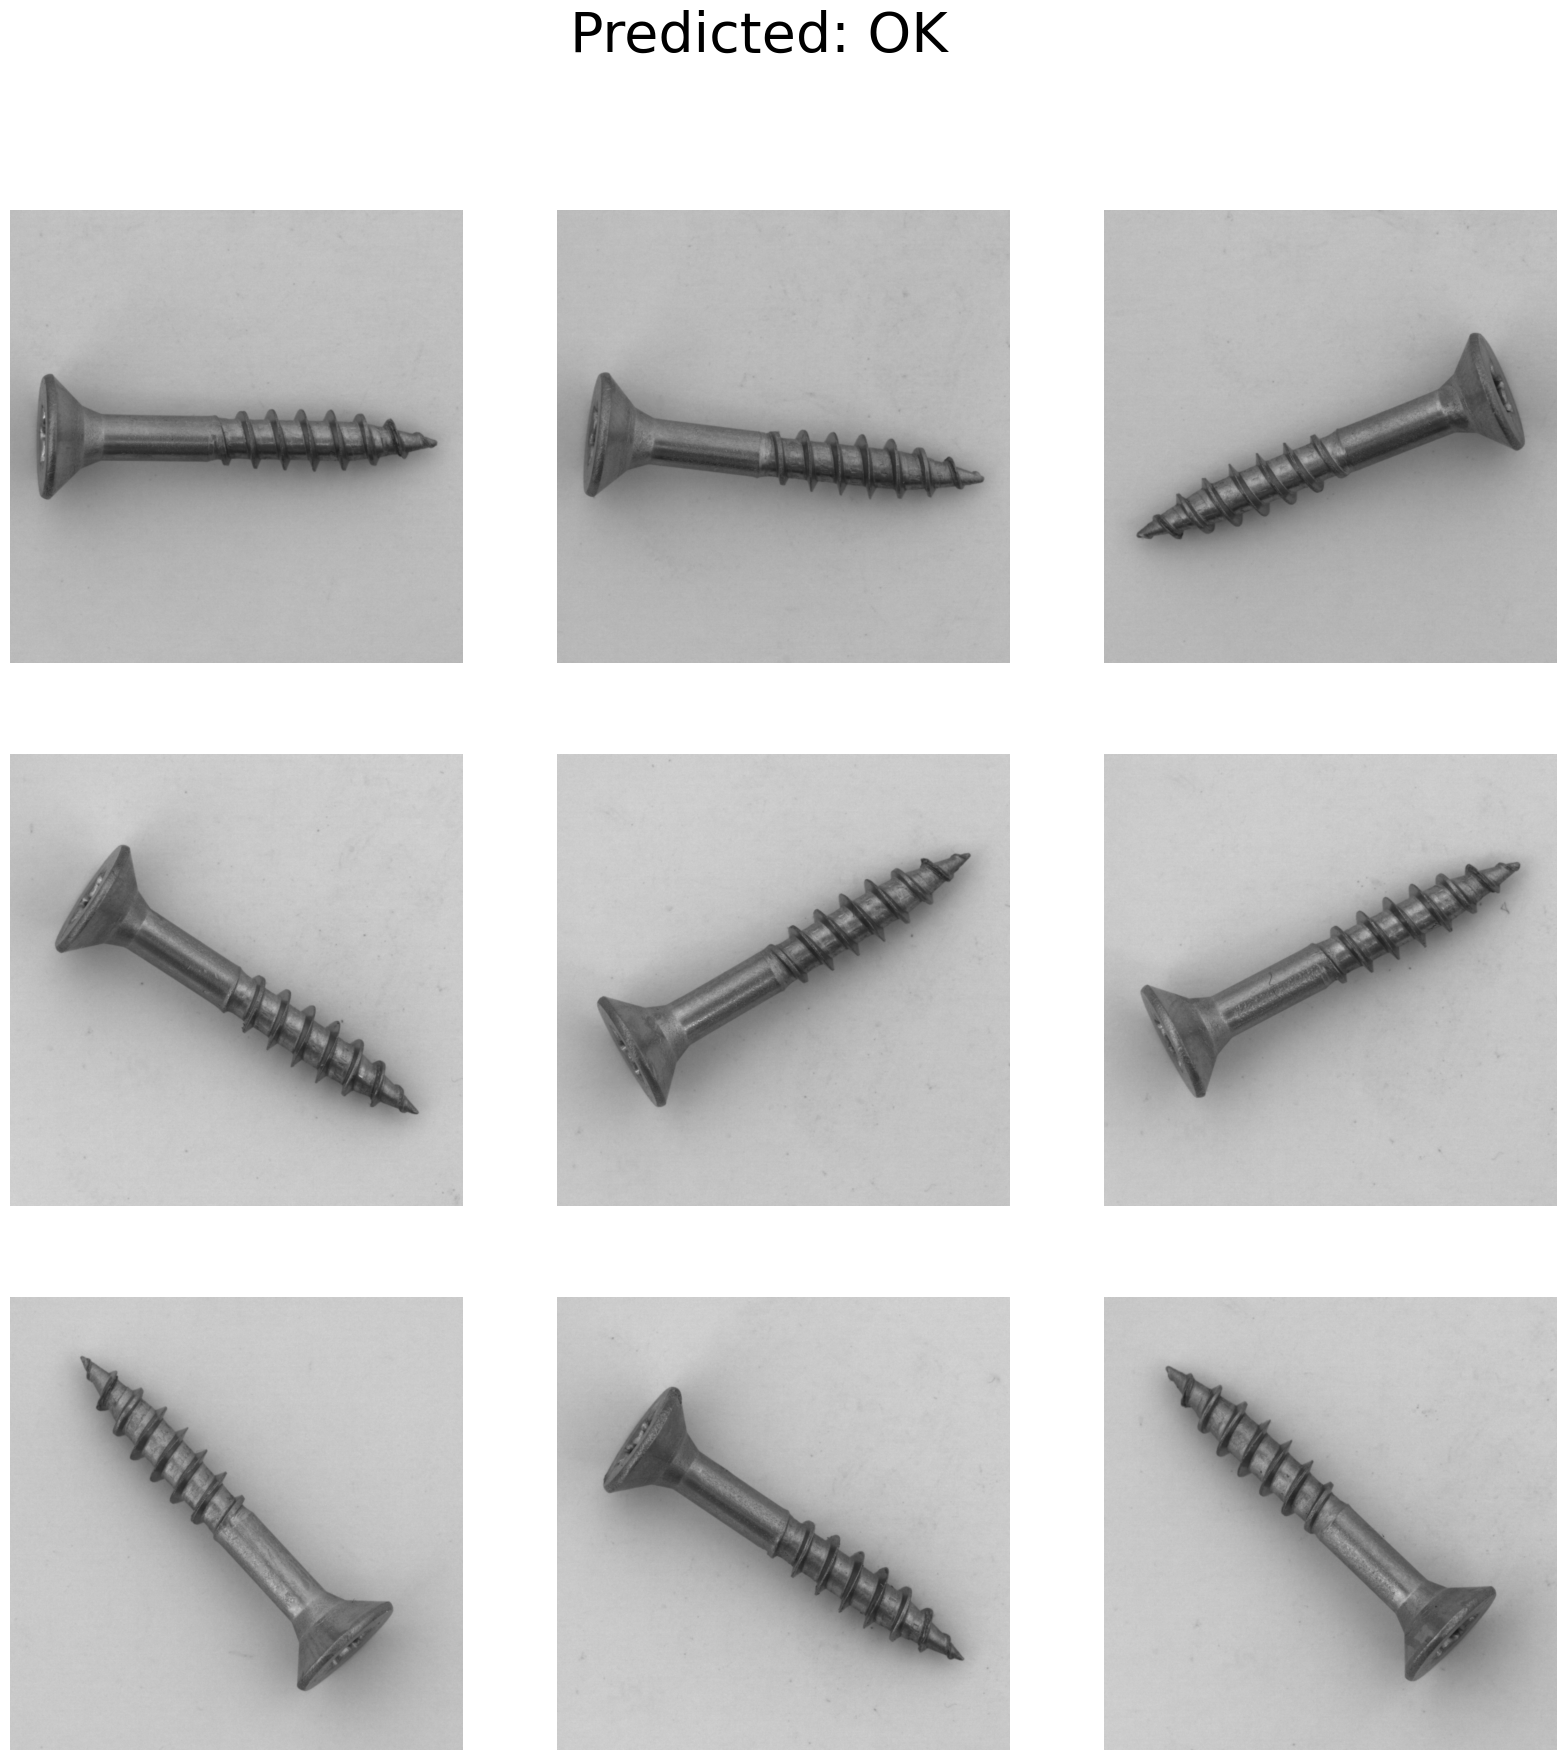

In [65]:
show_predictions_grid(test_img_paths, y_pred, 1,Path('plots') / "predicted_defective_lr.pdf",600)
show_predictions_grid(test_img_paths, y_pred, 0,Path('plots') / "predicted_not_defective_lr.pdf",600)

#### ResNet50

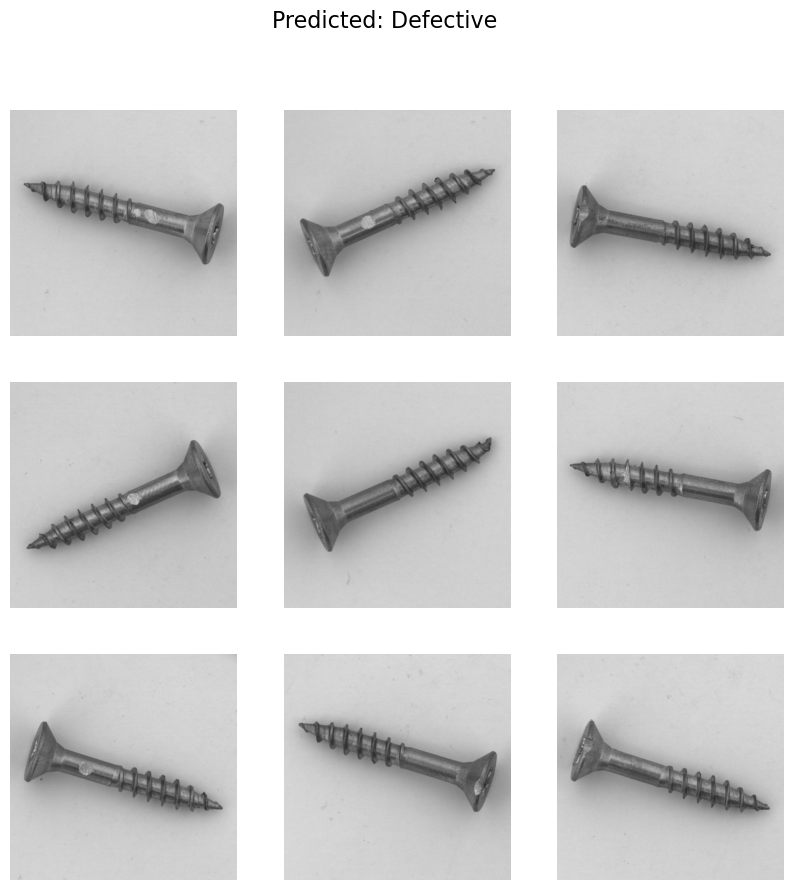

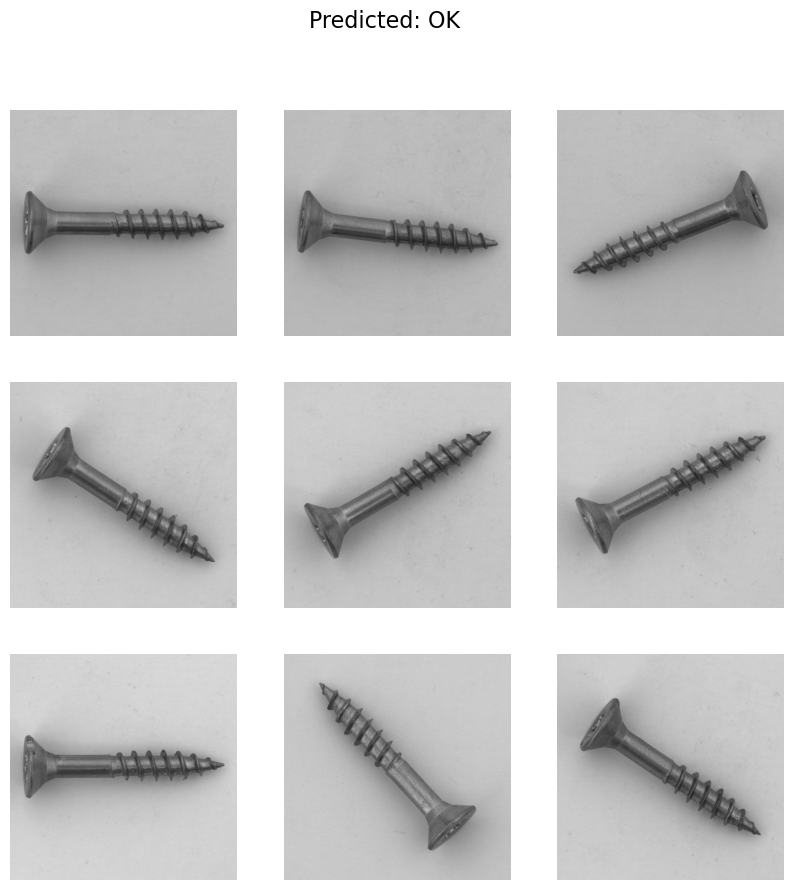

In [ ]:
show_predictions_grid(test_img_paths, y_labels2, 1,Path('plots') / "predicted_defective_r50.pdf",600)
show_predictions_grid(test_img_paths, y_labels2, 0,Path('plots') / "predicted_not_defective_r50.pdf",600)

In [66]:
agreement = np.mean(y_labels2 == y_pred)
print(f"Agreement between models: {agreement:.2%}")

Agreement between models: 81.67%
